In [83]:
import numpy as np
#from common import *
#from noisyGD import *
from autodp.calibrator_zoo import eps_delta_calibrator
from autodp.autodp_core import Mechanism
from autodp.mechanism_zoo import GaussianMechanism
from autodp.transformer_zoo import ComposeGaussian

torch.manual_seed(0)

In [84]:
#common
def add_ones(data):
    # add ones column to raw data X
    # X should be n x d form and the return is in n x (d+1) form
    ones = np.repeat(1, data.shape[0])
    add_ones_data = np.insert(data, data.shape[1], ones, axis=1)
    return add_ones_data


def one_hot_encoding(y, category=4):
    # y is in {0,1,2,3}, do one_hot_encoding
    # return a matrix in 4 x n form
    enc = np.zeros([category, y.shape[0]])
    for j in range(y.shape[0]):
        enc[y[j],j]=1
    return enc


def softmax_activation(z):
    exponentials = torch.exp(z)
    exponentials_row_sums = torch.sum(exponentials, axis=1).unsqueeze(1)
    return exponentials / exponentials_row_sums


def cross_entropy_loss(y_one_hot, activations):
    loss = -torch.mean(torch.sum(y_one_hot * torch.log(activations), axis=1))    
    return loss


def add_gauss_noise(sigma, dim1, dim2):
    gauss_noise = torch.normal(mean=0, std=sigma, size=(dim1, dim2))
    return gauss_noise

In [85]:
# noisyGD
class NoisyGD_mech(Mechanism):
    def __init__(self,sigma,coeff,name='NoisyGD'):
        Mechanism.__init__(self)
        self.name = name
        self.params={'sigma':sigma,'coeff':coeff}
        
        # ----------- Implement noisy-GD here with "GaussianMechanism" and "ComposeGaussian" ----------------
        gm = GaussianMechanism(sigma, name='Release_gradient')
        compose = ComposeGaussian()
        mech = compose([gm],[coeff])
        # ------------- return a Mechanism object named 'mech' --------------------s
        self.set_all_representation(mech)       

        
def cal_grad(w, X, y, A):
    # calculate the full gradient
    w_gradients = -torch.mm(X.transpose(0, 1), y - A)
    
    return w_gradients


def clip_grad(w, threshod):
    #clip gradient per example
    clip = np.minimum(1., threshod/np.linalg.norm(w, 'fro'))
    
    return clip


def theoretical_lr_choice(beta_L, f0_minus_fniter_bound, dim, sigma, niter):
    # beta_L is the gradient lipschitz constant for the whole objective function
    # sigma is the variance of the gradient noise in each coordinate  (notice that this is the noise multiplier * GS)
    
    return np.minimum(1/beta_L,np.sqrt(2*f0_minus_fniter_bound / (dim * sigma**2 *beta_L*niter)))


def find_appropriate_niter(sigma, eps, delta):
    # Use autodp calibrator for selecting 'niter'
    NoisyGD_fix_sigma = lambda x:  NoisyGD_mech(sigma,x)
    calibrate = eps_delta_calibrator()
    mech = calibrate(NoisyGD_fix_sigma, eps, delta, [0,500000])
    niter = int(np.floor(mech.params['coeff']))
    
    return niter


def run_noisyGD(niter, learning_rate, clip_threshold, sigma, X, y, w, clip_or_not=False):
    record_loss = []
    dim1 = w.shape[0]
    dim2 = w.shape[1]
    for i in range(niter):
        Z = torch.mm(X, w)
        A = softmax_activation(Z)
        loss = cross_entropy_loss(y, A)
        record_loss.append(loss)
        
        w_gradients = cal_grad(w, X, y, A)
        
        if clip_or_not == False:
            w -= learning_rate * (w_gradients + add_gauss_noise(sigma, dim1, dim2))
        else:
            w -= learning_rate * (w_gradients*clip_grad(w_gradients,clip_threshold) + add_gauss_noise(sigma, dim1, dim2))
                
    return w, record_loss 
    

In [86]:
# Generate data.
m = 20000
n = 50
np.random.seed(1)
X_ori = np.random.randn(m, n)
y_ori = np.array([1, 2, 2, 2, 1, 0, 3, 0, 2, 2, 1, 3, 3, 1, 0, 0, 0, 1, 0, 1])
y_ori = np.repeat(y_ori, m/20)
X1 = add_ones(X_ori)
y1 = np.transpose(one_hot_encoding(y_ori))

# Pytorch - NoisyGD

In [133]:
import torch 
from torch import tensor


X_numpy = X1
y_numpy = y1

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy, dtype=torch.float32)
w = torch.rand((n+1, 4), requires_grad=False)

beta_L = m/2
f0_minus_fniter_bound  = m*np.log(2) # ADD YOUR CODE HERE
GS = 1
sigma = 1000
eps = 0.1
delta = 0.001
clip_threshold = 2000

n_iterations = find_appropriate_niter(sigma, eps, delta)
learning_rate = theoretical_lr_choice(beta_L,f0_minus_fniter_bound,n,sigma*GS,n_iterations)

print(n_iterations)

3301


In [134]:
#### begin training!
a,b = run_noisyGD(niter=n_iterations, 
                  learning_rate=learning_rate, 
                  clip_threshold = clip_threshold, 
                  sigma=sigma, 
                  X=X, 
                  y=y, 
                  w=w,
                 clip_or_not=True
                 )

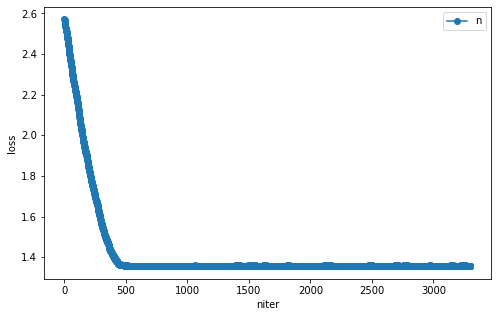

In [135]:
import matplotlib.pyplot as plt
#%matplotlib inline 
plt.figure(figsize=(8, 5))
plt.plot(np.arange(n_iterations), b,'o-')
plt.legend('noisyGD')
plt.xlabel('niter')
plt.ylabel('loss')
plt.show()